In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Bering = pd.read_excel(filepath, sheet_name='Bering-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Bering)
fp.date_time(Bering)

,Extent,Date
0,320266.650,1979-01-01
1,541778.338,1979-02-01
2,638262.988,1979-03-01
3,423025.159,1979-04-01
4,215587.216,1979-05-01
...,...,...
488,317377.493,2023-05-01
489,39601.476,2023-06-01
490,16935.702,2023-07-01
491,1305.744,2023-09-01


In [5]:
scaler = MinMaxScaler()
Bering['Extent'] = scaler.fit_transform(Bering['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 3
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Bering['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((479, 12, 1), (479,))

In [8]:
X_train, y_train = X[:384], y[:384]
X_val, y_val = X[384:432], y[384:432]
X_test, y_test = X[432:], y[432:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Bering_model_LT3/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
48/48 [==============================] - 34s 540ms/step - loss: 0.1418 - root_mean_squared_error: 0.3766 - val_loss: 0.0416 - val_root_mean_squared_error: 0.2039
Epoch 2/50
48/48 [==============================] - 24s 517ms/step - loss: 0.0860 - root_mean_squared_error: 0.2933 - val_loss: 0.0389 - val_root_mean_squared_error: 0.1973
Epoch 3/50
48/48 [==============================] - 27s 575ms/step - loss: 0.0691 - root_mean_squared_error: 0.2629 - val_loss: 0.0369 - val_root_mean_squared_error: 0.1921
Epoch 4/50
48/48 [==============================] - 33s 693ms/step - loss: 0.0544 - root_mean_squared_error: 0.2332 - val_loss: 0.0246 - val_root_mean_squared_error: 0.1568
Epoch 5/50
48/48 [==============================] - 26s 560ms/step - loss: 0.0380 - root_mean_squared_error: 0.1948 - val_loss: 0.0180 - val_root_mean_squared_error: 0.1341
Epoch 6/50
48/48 [==============================] - 23s 495ms/step - loss: 0.0274 - root_mean_squared_error: 0.1656 - val_loss: 0.0170 

48/48 [==============================] - 3s 58ms/step - loss: 0.0122 - root_mean_squared_error: 0.1103 - val_loss: 0.0340 - val_root_mean_squared_error: 0.1843
Epoch 44/50
48/48 [==============================] - 3s 53ms/step - loss: 0.0127 - root_mean_squared_error: 0.1125 - val_loss: 0.0335 - val_root_mean_squared_error: 0.1830
Epoch 45/50
48/48 [==============================] - 3s 54ms/step - loss: 0.0131 - root_mean_squared_error: 0.1146 - val_loss: 0.0353 - val_root_mean_squared_error: 0.1879
Epoch 46/50
48/48 [==============================] - 3s 60ms/step - loss: 0.0120 - root_mean_squared_error: 0.1096 - val_loss: 0.0331 - val_root_mean_squared_error: 0.1821
Epoch 47/50
48/48 [==============================] - 3s 56ms/step - loss: 0.0125 - root_mean_squared_error: 0.1117 - val_loss: 0.0361 - val_root_mean_squared_error: 0.1900
Epoch 48/50
48/48 [==============================] - 3s 54ms/step - loss: 0.0126 - root_mean_squared_error: 0.1120 - val_loss: 0.0338 - val_root_mean_sq

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

4.392935883998871 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

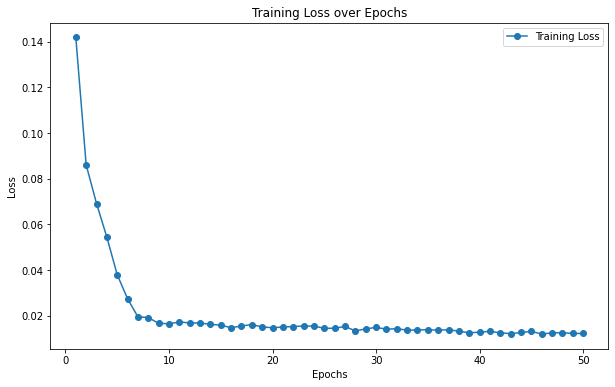

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

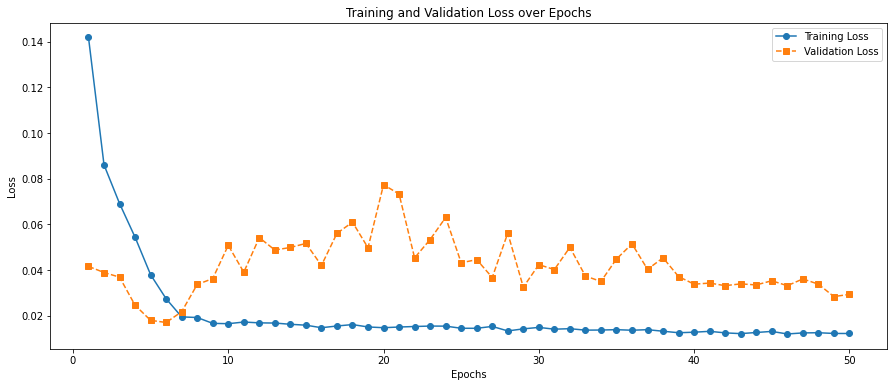

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Bering_model_LT3/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 3s 18ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.11643773129166217
MAE : 0.08772543818326534


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,43188.789062,2490.551
1,72250.437500,1707.377
2,125150.742188,11293.282
3,191886.578125,49957.406
4,263683.937500,151973.751
5,334805.093750,466524.938
6,395391.843750,708542.184
7,429281.812500,652598.000
8,329628.781250,414216.785
9,115847.773438,236263.303


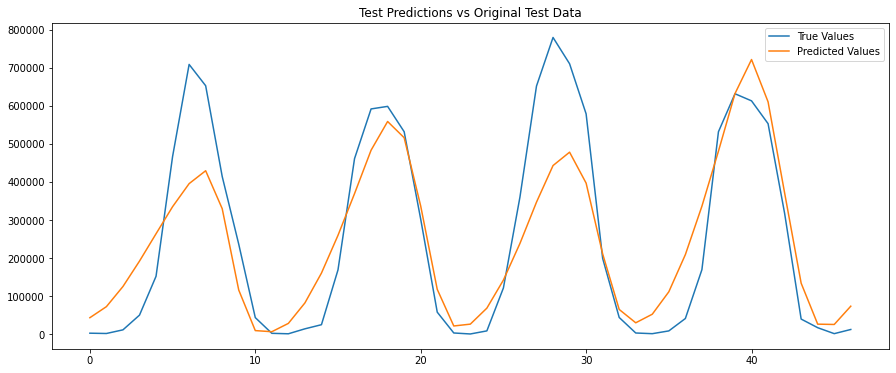

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

15/15 [==============================] - 0s 24ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

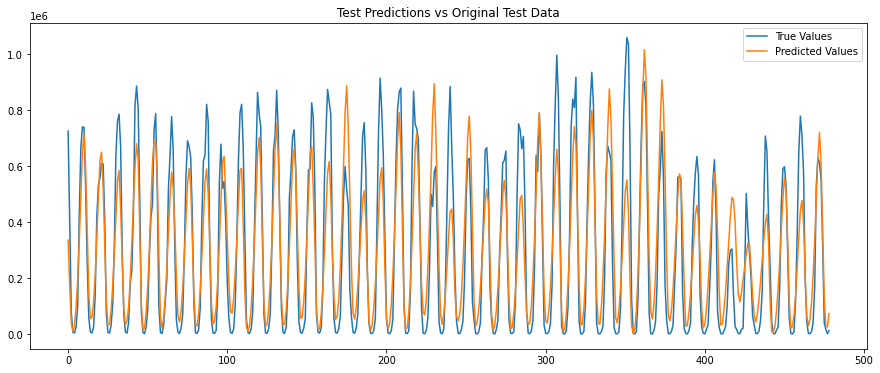

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()